# Initializing

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import comet_ml
import os
import torch
from torch.utils.data import DataLoader
from pathlib import Path

from src.utils.coco import COCODataset
from src.utils.pretty_print import *
from src.models import get_model_maskrcnn
from src.utils.train import maskrcnn_training_testing_loop
from src.utils.comet import CometLogger
from dotenv import load_dotenv

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

# Datasets

In [6]:
slide_path = Path("/storage01/bolma/dev/data/datasets/WSI-ROI/slides/annotations.json")

In [7]:
train_dataset = COCODataset(
    annotation_file=slide_path,
    train=True,
    transform=None,
    random_seed=42,
)

test_dataset = COCODataset(
    annotation_file=slide_path,
    train=False,
    transform=None,
    random_seed=42,
)

# Checks
train_images = set(id for id in train_dataset.image_ids)
test_images = set(id for id in test_dataset.image_ids)

print(f"Training image id-s: \t{train_images}")
print(f"\nTest image id-s: \t{test_images}")

# Overlapping images between datasets
overlapping_images = train_images.intersection(test_images)

if overlapping_images:
    print("\n[WARNING]: Overlapping images found:")
    for img in overlapping_images:
        print(f"- {img}")
else:
    print_success("Datasets are properly split and ready to use!")



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

‚úÖ Loaded training set with 41 images

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!

‚úÖ Loaded test set with 11 images

Training image id-s: 	{0, 1, 2, 4, 6, 7, 8, 9, 10, 11, 14, 15, 16, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 36, 37, 38, 39, 40, 42, 44, 45, 46, 48, 49, 51}

Test image id-s: 	{32, 3, 5, 41, 43, 12, 13, 47, 17, 50, 19}

‚úÖ Datasets are properly split and ready to use!


## Dataloaders

In [8]:
BATCH_SIZE = 1
NUM_WORKERS = 2

In [9]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    #collate_fn=lambda x: tuple(zip(*x))  # To handle variable size images/masks
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    #collate_fn=lambda x: tuple(zip(*x))
)

print_info(f"Created DataLoaders with batch size {BATCH_SIZE}")
print(f"\t- Training batches: {len(train_dataloader)}")
print(f"\t- Test batches: {len(test_dataloader)}")


‚ÑπÔ∏è Created DataLoaders with batch size 1
	- Training batches: 41
	- Test batches: 11


## Print dataset images

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_dataloader_batch(dataloader, figsize=(15, 4)):
    """Visualize sample images.
    
    Args:
        dataloader: PyTorch dataloader containing (image, target) pairs
        num_images: Number of images to display (default: 2)
        figsize: Figure size (width, height) in inches
    """
    images, targets = next(iter(dataloader))
    
    plt.figure(figsize=figsize)
    
    for idx in range(len(images)):
        img = images[idx].cpu().numpy().transpose(1, 2, 0)
        img = (img - img.min()) / (img.max() - img.min())
        
        # Plot original image
        plt.imshow(img)
        
        # Create combined mask
        masks = targets['masks'][idx]
        combined_mask = torch.zeros_like(masks[0])
        
        # Combine all masks
        for mask in masks:
            combined_mask = torch.logical_or(combined_mask, mask)
        
        # Create mask overlay
        mask_img = combined_mask.cpu().numpy()
        overlay = img.copy()
        overlay[mask_img == 1] = np.array([0, 1, 0])
        plt.imshow(overlay, alpha=0.3)
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Training Dataset Examples:


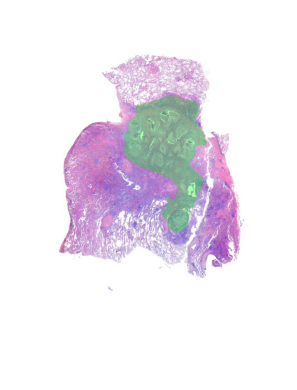


Test Dataset Examples:


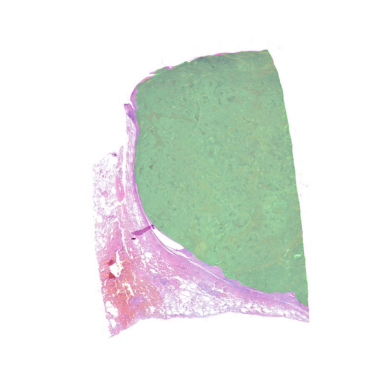

In [19]:
import warnings
# Visualize training data
print("Training Dataset Examples:")
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Creating a tensor from a list of numpy.ndarrays is extremely slow.')
    visualize_dataloader_batch(train_dataloader)

# Visualize test data
print("\nTest Dataset Examples:")
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Creating a tensor from a list of numpy.ndarrays is extremely slow.')
    visualize_dataloader_batch(test_dataloader)

# Training

## Model architecture

In [13]:
maskrcnn = get_model_maskrcnn(num_classes=2, 
                      box_score_thresh=0.1,
                      box_nms_thresh=0.3,
                      box_fg_iou_thresh=0.5,
                      box_bg_iou_thresh=0.4,
                      box_detections_per_img=5,
                      image_mean = [0.485, 0.456, 0.406],
                      image_std = [0.229, 0.224, 0.225])

optimizer = torch.optim.SGD(maskrcnn.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5)

## Training loop

In [ ]:
import warnings

# For logging to comet.ml, a cloud service
load_dotenv()
api_key = os.getenv('COMET_API_KEY')
comet_logger = CometLogger(api_key=api_key,
                        project_name="msc-thesis",
                        experiment_name="MaskRCNN",
                        log_env_details=False,)

# Supressing some warning coming from a library with legacy code
with warnings.catch_warnings():
    warnings.filterwarnings('ignore', message='Creating a tensor from a list of numpy.ndarrays is extremely slow.')
    # Training loop
    maskrcnn_training_testing_loop(maskrcnn,device, train_dataloader, optimizer, scheduler, n_epochs=30, box_score_thresh=0.5, comet_logger=comet_logger)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/bolf-marton/msc-thesis/0bb3b21112024ab1aa946c162f874e5a




üöÄ STARTING TRAINING
---------------------
Epoch 1/30 - MaskRCNN
---------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:13<00:00,  2.94it/s]


Train ‚Äì Mean Loss: 1.2246


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.74it/s]


Test ‚Äì IoU: 0.3821, Loss: 0.8961
---------------------
Epoch 2/30 - MaskRCNN
---------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.31it/s]


Train ‚Äì Mean Loss: 0.9243


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.42it/s]


Test ‚Äì IoU: 0.3295, Loss: 0.8405
---------------------
Epoch 3/30 - MaskRCNN
---------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.48it/s]


Train ‚Äì Mean Loss: 0.9224


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:05<00:00,  7.28it/s]


Test ‚Äì IoU: 0.4215, Loss: 0.9624
---------------------
Epoch 4/30 - MaskRCNN
---------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.67it/s]


Train ‚Äì Mean Loss: 0.8870


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.45it/s]


Test ‚Äì IoU: 0.4199, Loss: 0.7780
---------------------
Epoch 5/30 - MaskRCNN
---------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:05<00:00,  7.01it/s]


Train ‚Äì Mean Loss: 0.7625


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:05<00:00,  7.32it/s]


Test ‚Äì IoU: 0.4326, Loss: 0.6947
---------------------
Epoch 6/30 - MaskRCNN
---------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.32it/s]


Train ‚Äì Mean Loss: 0.6902


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.63it/s]


Test ‚Äì IoU: 0.3879, Loss: 0.6181
---------------------
Epoch 7/30 - MaskRCNN
---------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.27it/s]


Train ‚Äì Mean Loss: 0.6442


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.83it/s]


Test ‚Äì IoU: 0.4060, Loss: 0.6833
---------------------
Epoch 8/30 - MaskRCNN
---------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:05<00:00,  6.83it/s]


Train ‚Äì Mean Loss: 0.6264


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.29it/s]


Test ‚Äì IoU: 0.4635, Loss: 0.5538
---------------------
Epoch 9/30 - MaskRCNN
---------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.02it/s]


Train ‚Äì Mean Loss: 0.5223


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.47it/s]


Test ‚Äì IoU: 0.4546, Loss: 0.4137
----------------------
Epoch 10/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:05<00:00,  6.90it/s]


Train ‚Äì Mean Loss: 0.4274


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.26it/s]


Test ‚Äì IoU: 0.4894, Loss: 0.4094
----------------------
Epoch 11/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.41it/s]


Train ‚Äì Mean Loss: 0.4579


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.35it/s]


Test ‚Äì IoU: 0.3890, Loss: 0.4517
----------------------
Epoch 12/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:05<00:00,  6.91it/s]


Train ‚Äì Mean Loss: 0.4300


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.27it/s]


Test ‚Äì IoU: 0.4773, Loss: 0.3950
----------------------
Epoch 13/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.19it/s]


Train ‚Äì Mean Loss: 0.4241


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.40it/s]


Test ‚Äì IoU: 0.4358, Loss: 0.3965
----------------------
Epoch 14/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.26it/s]


Train ‚Äì Mean Loss: 0.3980


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.65it/s]


Test ‚Äì IoU: 0.4599, Loss: 0.3975
----------------------
Epoch 15/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.27it/s]


Train ‚Äì Mean Loss: 0.3776


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:05<00:00,  7.11it/s]


Test ‚Äì IoU: 0.4823, Loss: 0.3572
----------------------
Epoch 16/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.17it/s]


Train ‚Äì Mean Loss: 0.3686


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.52it/s]


Test ‚Äì IoU: 0.4972, Loss: 0.3274
----------------------
Epoch 17/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.46it/s]


Train ‚Äì Mean Loss: 0.3025


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.34it/s]


Test ‚Äì IoU: 0.4818, Loss: 0.2832
----------------------
Epoch 18/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.15it/s]


Train ‚Äì Mean Loss: 0.2952


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.34it/s]


Test ‚Äì IoU: 0.5073, Loss: 0.2607
----------------------
Epoch 19/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.20it/s]


Train ‚Äì Mean Loss: 0.2806


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.62it/s]


Test ‚Äì IoU: 0.4733, Loss: 0.3042
----------------------
Epoch 20/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.38it/s]


Train ‚Äì Mean Loss: 0.2697


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.67it/s]


Test ‚Äì IoU: 0.4695, Loss: 0.2614
----------------------
Epoch 21/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.79it/s]


Train ‚Äì Mean Loss: 0.2605


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.53it/s]


Test ‚Äì IoU: 0.4622, Loss: 0.2408
----------------------
Epoch 22/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.34it/s]


Train ‚Äì Mean Loss: 0.2614


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:05<00:00,  7.03it/s]


Test ‚Äì IoU: 0.4870, Loss: 0.2253
----------------------
Epoch 23/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.13it/s]


Train ‚Äì Mean Loss: 0.2314


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.23it/s]


Test ‚Äì IoU: 0.4489, Loss: 0.2366
----------------------
Epoch 24/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.49it/s]


Train ‚Äì Mean Loss: 0.2371


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:05<00:00,  7.35it/s]


Test ‚Äì IoU: 0.4652, Loss: 0.2143
----------------------
Epoch 25/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:05<00:00,  7.00it/s]


Train ‚Äì Mean Loss: 0.2065


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.36it/s]


Test ‚Äì IoU: 0.4813, Loss: 0.1915
----------------------
Epoch 26/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:05<00:00,  6.93it/s]


Train ‚Äì Mean Loss: 0.1893


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.67it/s]


Test ‚Äì IoU: 0.4762, Loss: 0.1773
----------------------
Epoch 27/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.35it/s]


Train ‚Äì Mean Loss: 0.1805


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.40it/s]


Test ‚Äì IoU: 0.4811, Loss: 0.1686
----------------------
Epoch 28/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:05<00:00,  6.87it/s]


Train ‚Äì Mean Loss: 0.1688


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:05<00:00,  6.87it/s]


Test ‚Äì IoU: 0.4752, Loss: 0.1639
----------------------
Epoch 29/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:05<00:00,  6.94it/s]


Train ‚Äì Mean Loss: 0.1635


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:05<00:00,  6.87it/s]


Test ‚Äì IoU: 0.4766, Loss: 0.1580
----------------------
Epoch 30/30 - MaskRCNN
----------------------


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.52it/s]


Train ‚Äì Mean Loss: 0.1579


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 41/41 [00:06<00:00,  6.61it/s]

Test ‚Äì IoU: 0.4629, Loss: 0.1584


In [ ]:
# Save some sample images with predictions to comet.ml
with torch.set_grad_enabled(False):
    comet_logger.upload_images(
        model = maskrcnn,
        device = device,
        dataloader = test_dataloader,
        confidence_thr = 0.5,
        entry_name = "sample_img",
        overwrite = True,
        indices = [0,1,2],
    )

comet_logger.end() # End the comet logger session

/storage01/bolma/dev/tumor-region-detection-thesis/src/utils/coco.py:118: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  "masks": torch.as_tensor(masks, dtype=torch.uint8)


In [ ]:
# Save the model weights
torch.save(maskrcnn.state_dict(), "src/models/weights/MaskRCNN_trained_weights.pth")